# Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection 
This is the code for the paper entitled "[**Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection**](https://arxiv.org/pdf/2409.03141)" accepted in Workshop on Autonomous Cybersecurity (AutonomousCyber 2024), ACM CCS 2024 (Top Cybersecurity Conference).  
Authors: Li Yang (liyanghart@gmail.com) and Abdallah Shami  

If you find this repository useful in your research, please cite:  
L. Yang and A. Shami, “Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection,” in Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber ’24), 2024 ACM SIGSAC Conference on Computer and Communications Security (CCS’24), 2024, pp. 1–11. doi: 10.1145/3689933.3690833.

```
@INPROCEEDINGS{3690833,
  author={Yang, Li and Shami, Abdallah},
  title = {Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection},
  booktitle = {Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber '24), ACM Conference on Computer and Communications Security (CCS) 2024},
  year = {2024},
  address = {Salt Lake City, UT, USA},
  pages = {1-11},
  doi = {10.1145/3689933.3690833}
}
```

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb
import catboost as cb
import time

## Dataset 1: CICIDS2017
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  

Due to the large size of this dataset and the file size limit of GitHub, the sampled subset of CICIDS2017 is used. The subsets are in the "Data" folder.  PS: The results might be different from the paper due to the size difference of the dataset.

The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes.


### Load data

In [3]:
# Read the dataset
df = pd.read_csv('../../datasets/output/train_final.csv', parse_dates=['Timestamp'])

In [4]:
df_test = pd.read_csv('../../datasets/output/test_final.csv', parse_dates=['Timestamp'])

In [5]:
df_test['Label'].value_counts()

Label
Benign          99591
Portscan        31808
Slowhttptest      894
Name: count, dtype: int64

In [6]:
df_benign = df[df['Label'] == 'Benign'].sort_values(by='Timestamp')
df_ps = df[df['Label'] == 'Portscan'].sort_values(by='Timestamp')
df_dos = df[df['Label'] == 'Slowhttptest'].sort_values(by='Timestamp')

In [7]:
df_benign_val = df_benign.iloc[-120990:]
df_benign_train = df_benign[~df_benign.index.isin(df_benign_val.index)]
df_ps_val = df_ps.iloc[-31786:]
df_ps_train = df_ps[~df_ps.index.isin(df_ps_val.index)]
df_dos_val = df_dos.iloc[-1139:]
df_dos_train = df_dos[~df_dos.index.isin(df_dos_val.index)]

In [31]:
# df['Label'] = df['Label'].map({
#     "Benign": "Benign",
#     "Slowloris": "Slowloris"
# })
# df = df.dropna(subset=['Label'])
# df['Label'].value_counts(dropna=False)

In [30]:
# df_test[df_test['Label'] == 'Slowloris'].sort_values(by='Timestamp').reset_index().iloc[700]['Timestamp']

In [29]:
# df_test['Label'] = df_test['Label'].map({
#     "Benign": "Benign",
#     "Slowloris": "Slowloris"
# })
# df_test = df_test.dropna(subset=['Label'])
# df_test['Label'].value_counts(dropna=False)

In [24]:
# df_test[df_test['Label'] == 'Slowloris'].sort_values(by='Timestamp').iloc[:int(len(df_test[df_test['Label'] == 'Slowloris'])*(1/2))]

In [25]:
# randomizing = df_test[df_test['Timestamp'] <= pd.Timestamp('2017-07-05 13:08:15.865809')]
# df_test = df_test[~df_test.index.isin(randomizing.index)]

In [26]:
# df = pd.concat([df, randomizing])

In [27]:
# # print the class distribution of the last column
# df['Label'].value_counts()

In [28]:
# df_test['Label'].value_counts()

In [ ]:
# df_train = pd.concat([df_benign_train, df_ps_train, df_dos_train])
# df_val = pd.concat([df_benign_val, df_ps_val, df_dos_val])

In [8]:
# df_train['Label'].value_counts()

In [9]:
# df_val['Label'].value_counts()

In [ ]:
# df_train = df_train.drop(['index', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], axis=1)
# df_val = df_val.drop(['index', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], axis=1)
# df_test = df_test.drop(['index', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], axis=1)

In [11]:
df = df.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], axis=1)
df_test = df_test.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], axis=1)

In [12]:
X_test = df_test.drop('Label', axis=1)

In [13]:
y_test = df_test['Label']

### Data pre-processing

In [14]:
# Encode the dataset
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Label'])

In [15]:
df['Label'].value_counts()

Label
0    505798
1    127232
2      3933
Name: count, dtype: int64

In [16]:
y_test = labelencoder.transform(y_test)
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
df.isnull().any().any()

False

In [18]:
df.isna().any().any()

False

In [25]:
# address empty values
# if df.isnull().values.any() or np.isinf(df).values.any(): # if there is any empty or infinite values
#     print("THERE ARE")
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     df.fillna(0, inplace = True) 

In [43]:
# # Debug
# X_train = df.drop(['Label'],axis=1).values 
# y_train = df['Label'].values.reshape(-1,1)
# X_val = X_test
# y_val = y_test

In [19]:
# Split the dataset into training and testing
X = df.drop(['Label'],axis=1) 
y = df['Label'].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size = 0.75, test_size = 0.25, random_state = 0, stratify = y)
# 0.75 & 0.25 means 60% train and 20% validation FROM WHOLE DATASET (counting test)

In [ ]:
# X_train = df_train.drop(["Label"], axis=1)
# y_train = labelencoder.transform(df_train["Label"])
# X_val = df_val.drop(["Label"], axis=1)
# y_val = labelencoder.transform(df_val["Label"])

In [20]:
labelencoder.classes_

array(['Benign', 'Portscan', 'Slowhttptest'], dtype=object)

## Machine learning model training

### Training six base learners (for comparison purposes): 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

#### DT

Training time:  15.562807559967041
Prediction time per sample:  0.0011877000562824623
Cross-Validation scores:  [0.99994976 0.99996232 0.99989324]
Mean of Cross-Validation scores:  0.9999351086157521
Accuracy of DT: 0.9999372021024736
Precision of DT: 0.9999377144702413
Recall of DT: 0.9999372021024736
F1-score of DT: 0.9999373298352751
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       0.99      1.00      1.00       983

    accuracy                           1.00    159241
   macro avg       1.00      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



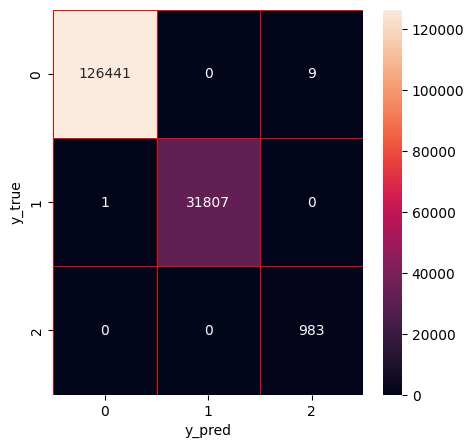

In [21]:
# %%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt


# Decision tree training and prediction with 3-fold cross-validation
dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_score(dt, X_train, y_train, cv=3, n_jobs=4)

# calculate the training time
start = time.time()
dt.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val)*1000)

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00026220222591887953
Accuracy of DT: 0.9947313916836114
Precision of DT: 0.9948118528297237
Recall of DT: 0.9947313916836114
F1-score of DT: 0.9947470087647421
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     99591
           1       0.98      1.00      0.99     31808
           2       1.00      1.00      1.00       894

    accuracy                           0.99    132293
   macro avg       0.99      1.00      0.99    132293
weighted avg       0.99      0.99      0.99    132293



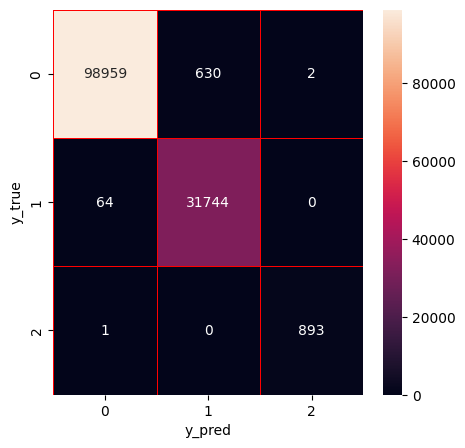

In [22]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test)*1000)

y_true = y_test

# Print out the cross-validation scores and mean of them
# print('Cross-Validation scores: ', dt_scores)
# print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### RF

Training time:  21.641238927841187
Prediction time:  0.0011719283560780184 ms
Cross-Validation scores:  [0.99998116 0.99998116 0.99991208]
Mean of Cross-Validation scores:  0.9999581345509476
Accuracy of RF: 0.999981160630742
Precision of RF: 0.9999811607300658
Recall of RF: 0.999981160630742
F1-score of RF: 0.9999811606186307
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00       983

    accuracy                           1.00    159241
   macro avg       1.00      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



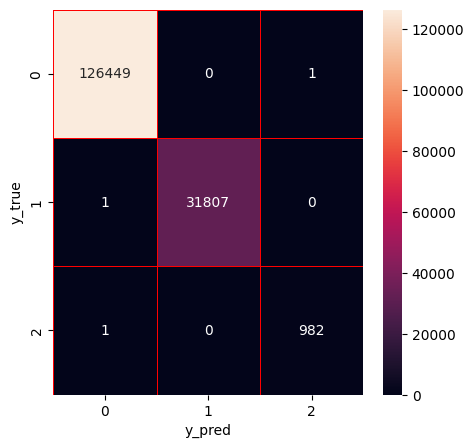

In [23]:
# %%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0, n_jobs=8)
rf_scores = cross_val_score(rf, X_train, y_train, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
rf.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# Evaluation metrics
rf_score = rf.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Prediction time:  0.0011160814632266895 ms
Accuracy of RF: 0.9993650457696175
Precision of RF: 0.9993653055355233
Recall of RF: 0.9993650457696175
F1-score of RF: 0.9993646133012205
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99591
           1       1.00      1.00      1.00     31808
           2       1.00      0.99      0.99       894

    accuracy                           1.00    132293
   macro avg       1.00      0.99      1.00    132293
weighted avg       1.00      1.00      1.00    132293



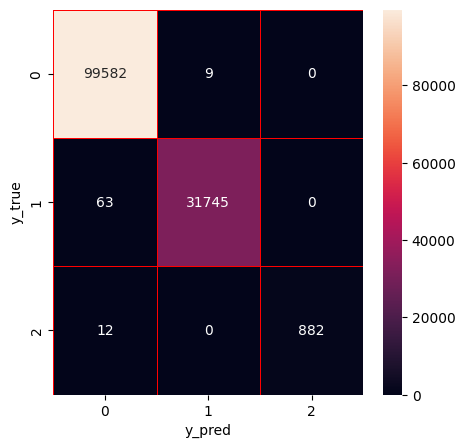

In [24]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
rf_score = rf.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### ET

Training time:  9.212179899215698
Prediction time:  0.0012989329140087537 ms
Cross-Validation scores:  [0.99998744 0.99998116 0.9999058 ]
Mean of Cross-Validation scores:  0.9999581345378022
Accuracy of ET: 0.9999874404204947
Precision of ET: 0.9999874468023948
Recall of ET: 0.9999874404204947
F1-score of ET: 0.9999874419674231
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00       983

    accuracy                           1.00    159241
   macro avg       1.00      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



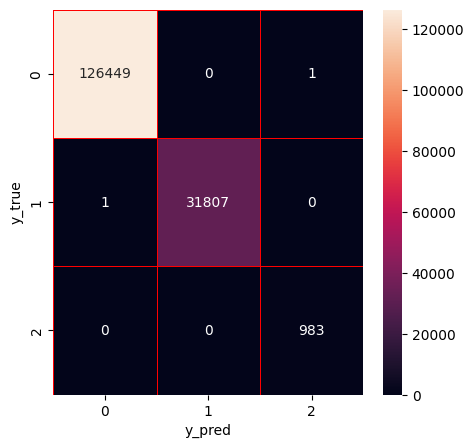

In [25]:
# %%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=8)
et_scores = cross_val_score(et, X_train, y_train, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
et.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(X_val) * 1000, 'ms')


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

# Evaluation metrics
et_score = et.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### XGBoost

Training time:  3.7569851875305176
Prediction time per sample:  0.0003753257405212093
Cross-Validation scores:  [0.99998744 0.99998116 0.99994348]
Mean of Cross-Validation scores:  0.9999706941961796
Accuracy of XGBoost: 0.9999874404204947
Precision of XGBoost: 0.9999874404204947
Recall of XGBoost: 0.9999874404204947
F1-score of XGBoost: 0.9999874404204947
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00       983

    accuracy                           1.00    159241
   macro avg       1.00      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



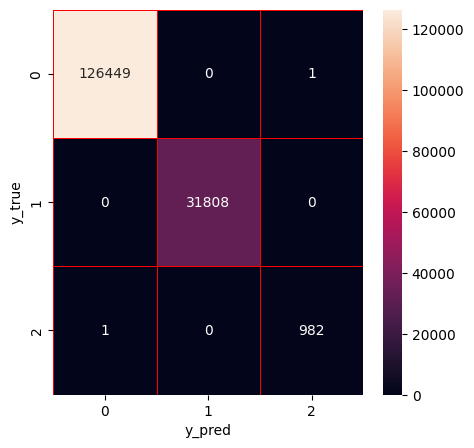

In [26]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=8)
xg_scores = cross_val_score(xg, X_train, y_train, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
xg.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

# Evaluation metrics
xg_score = xg.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16868
[LightGBM] [Info] Number of data points in the train set: 318482, number of used features: 82
[LightGBM] [Info] Start training from score -0.230576
[LightGBM] [Info] Start training from score -1.610701
[LightGBM] [Info] Start training from score -5.087056
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info]

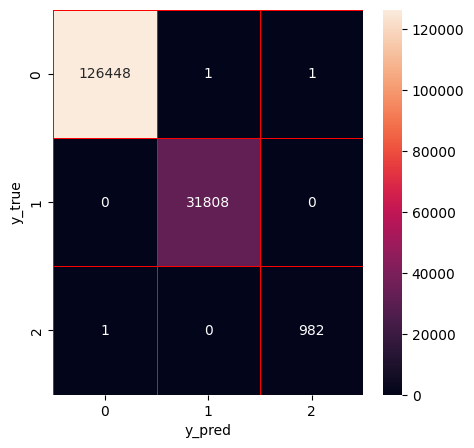

In [27]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)
lgbm_scores = cross_val_score(lgbm, X_train, y_train, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
lgbm.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)



y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Prediction time per sample:  0.0009662122288793934
Cross-Validation scores:  [0.99999372 0.99997488 0.99991208]
Mean of Cross-Validation scores:  0.9999602278141987
Accuracy of LightGBM: 0.9992818970013531
Precision of LightGBM: 0.9992818057974212
Recall of LightGBM: 0.9992818970013531
F1-score of LightGBM: 0.9992817855180982
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99591
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00       894

    accuracy                           1.00    132293
   macro avg       1.00      1.00      1.00    132293
weighted avg       1.00      1.00      1.00    132293



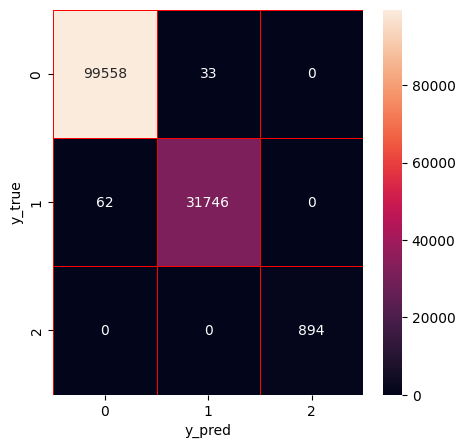

In [28]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)



y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Catboost

In [29]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, verbose=False, thread_count=8)
cat_scores = cross_val_score(cat, X_train, y_train, cv=3, n_jobs=8)


# calculate the training time
start = time.time()
cat.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)


Training time:  59.261032581329346


Prediction time per sample:  0.00040353483521951274
Cross-Validation scores:  [0.99998744 0.99998116 0.99992464]
Mean of Cross-Validation scores:  0.9999644143669911
Accuracy of CatBoost: 0.9999874404204947
Precision of CatBoost: 0.9999874404204947
Recall of CatBoost: 0.9999874404204947
F1-score of CatBoost: 0.9999874404204947
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00       983

    accuracy                           1.00    159241
   macro avg       1.00      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



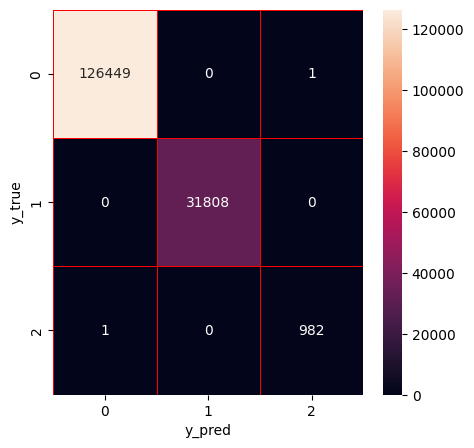

In [30]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

# Evaluation metrics
cat_score = cat.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [31]:
# record the results
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_val)
dt_prob_train=dt.predict_proba(X_train)
dt_prob_test=dt.predict_proba(X_val)

rf_train=rf.predict(X_train)
rf_test=rf.predict(X_val)
rf_prob_train=rf.predict_proba(X_train)
rf_prob_test=rf.predict_proba(X_val)

et_train=et.predict(X_train)
et_test=et.predict(X_val)
et_prob_train=et.predict_proba(X_train)
et_prob_test=et.predict_proba(X_val)

xg_train=xg.predict(X_train)
xg_test=xg.predict(X_val)
xg_prob_train=xg.predict_proba(X_train)
xg_prob_test=xg.predict_proba(X_val)

lgbm_train=lgbm.predict(X_train)
lgbm_test=lgbm.predict(X_val)
lgbm_prob_train=lgbm.predict_proba(X_train)
lgbm_prob_test=lgbm.predict_proba(X_val)

cat_train=cat.predict(X_train)
cat_test=cat.predict(X_val)
cat_prob_train=cat.predict_proba(X_train)
cat_prob_test=cat.predict_proba(X_val)


In [49]:
MODEL_OUTPUT_PREFS = "./models/prefs"

In [52]:
import joblib

joblib.dump(dt, f"{MODEL_OUTPUT_PREFS}/dt.pkl")
joblib.dump(rf, f"{MODEL_OUTPUT_PREFS}/rf.pkl")
joblib.dump(et, f"{MODEL_OUTPUT_PREFS}/et.pkl")
joblib.dump(xg, f"{MODEL_OUTPUT_PREFS}/xg.pkl")
joblib.dump(lgbm, f"{MODEL_OUTPUT_PREFS}/lgbm.pkl")
joblib.dump(cat, f"{MODEL_OUTPUT_PREFS}/cat.pkl")

['./models/prefs/cat.pkl']

In [35]:
import gc
gc.collect()

22987

## Model selection

In [36]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]

In [37]:
top_3_models

['xg', 'cat', 'lgbm']

## Model Ensemble

In [38]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)


dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)
lgbm_test=lgbm_test.reshape(-1, 1)
cat_test=cat_test.reshape(-1, 1)

Training time of Stacking: 0.9095990657806396
Testing time of Stacking: 0.00010708107068747212
Accuracy of Stacking: 0.9999874404204947
Precision of Stacking: 0.9999874404204947
Recall of Stacking: 0.9999874404204947
F1-score of Stacking: 0.9999874404204947
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00       983

    accuracy                           1.00    159241
   macro avg       1.00      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



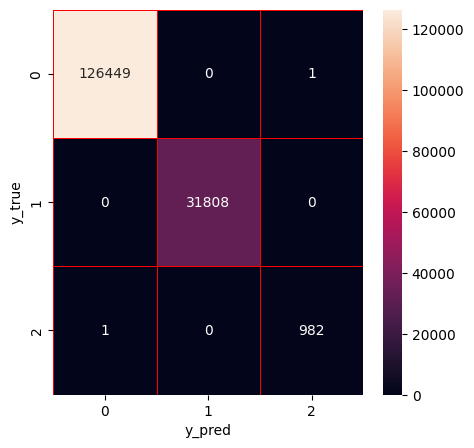

In [39]:
# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

# Stack the predictions of the top-3 models
x_train = np.concatenate(top_3_train_predictions, axis=1)
x_val = np.concatenate(top_3_test_predictions, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0, n_jobs=8).fit(x_train, y_train)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Training time of Stacking: 2.370976448059082
Testing time of Stacking: 0.00012071025114703672
Accuracy of Stacking: 0.9999372021024736
Precision of Stacking: 0.9999374302920562
Recall of Stacking: 0.9999372021024736
F1-score of Stacking: 0.9999372583849949
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       0.99      1.00      1.00       983

    accuracy                           1.00    159241
   macro avg       1.00      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



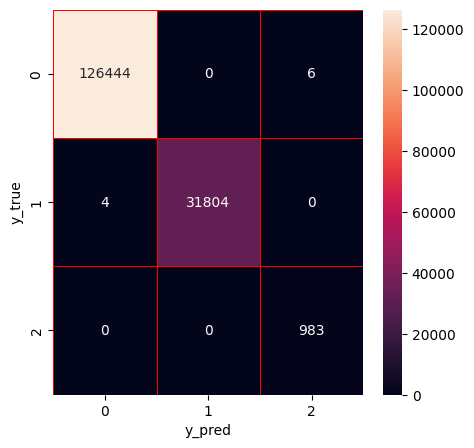

In [40]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_test_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Training time of Stacking: 2.2358696460723877
Testing time of Stacking: 8.190833520832688e-05
Accuracy of Stacking: 0.9999874404204947
Precision of Stacking: 0.9999874404204947
Recall of Stacking: 0.9999874404204947
F1-score of Stacking: 0.9999874404204947
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00       983

    accuracy                           1.00    159241
   macro avg       1.00      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



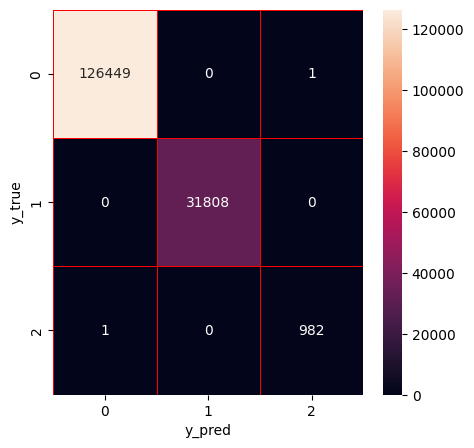

In [41]:
# Ensemble method 3: hybrid stacking

# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_test_predictions + top_3_test_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Automated Feature Selection

In [42]:
# Save the feature importance lists generated by base ML algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xg_feature = xg.feature_importances_
lgbm_feature = lgbm.feature_importances_
cat_feature = cat.feature_importances_

In [43]:
lgbm_feature = lgbm_feature/sum(lgbm_feature)
cat_feature = cat_feature/sum(cat_feature)

In [44]:
# Get the feature importances of the top-3 models
top_3_importances = [globals()[model.lower() + '_feature'] for model in top_3_models]

# Calculate the average importance of each feature
avg_feature = np.mean(top_3_importances, axis=0)

feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)


Features sorted by their score:
[(0.3246, 'Flow Duration'), (0.1019, 'Old Index'), (0.0475, 'SYN Flag Count'), (0.0412, 'Total Length of Fwd Packet'), (0.0372, 'Flow IAT Min'), (0.0231, 'Fwd Seg Size Min'), (0.0227, 'Fwd Packet Length Max'), (0.0221, 'FWD Init Win Bytes'), (0.0212, 'Flow IAT Max'), (0.021, 'Flow Packets/s'), (0.0206, 'Fwd Packets/s'), (0.0202, 'FIN Flag Count'), (0.0179, 'Fwd Header Length'), (0.0132, 'Fwd IAT Min'), (0.0128, 'Bwd IAT Std'), (0.0122, 'Down/Up Ratio'), (0.0121, 'Packet Length Mean'), (0.012, 'Flow IAT Std'), (0.0119, 'Bwd IAT Mean'), (0.0115, 'Total Fwd Packet'), (0.0112, 'Flow Bytes/s'), (0.0096, 'Bwd Packets/s'), (0.0096, 'Bwd Packet Length Std'), (0.0092, 'Subflow Fwd Packets'), (0.0088, 'Flow IAT Mean'), (0.0077, 'ACK Flag Count'), (0.0075, 'Fwd Packet Length Mean'), (0.0073, 'Packet Length Max'), (0.0061, 'Fwd Segment Size Avg'), (0.0052, 'RST Flag Count'), (0.0052, 'Bwd IAT Total'), (0.005, 'Bwd Packet Length Max'), (0.0048, 'Fwd IAT Mean'), (0.00

In [45]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break        

In [46]:
# regenerate the training and test sets with the selected features
# note that it uses random_state, so the results are the same, just the features are now selected

X_fs = X[fs]
X_train, X_val, y_train, y_val = train_test_split(X_fs, y, train_size=0.75, test_size=0.25, random_state=0, stratify=y)

In [53]:
CHECKPOINT_OUTPUT = "./models"

In [54]:
# save the dataset with the selected features
df_fs = pd.DataFrame(X_fs, columns=fs)
df_fs['Label'] = y
df_fs.to_csv(f'{CHECKPOINT_OUTPUT}/df_fs.csv', index=False)

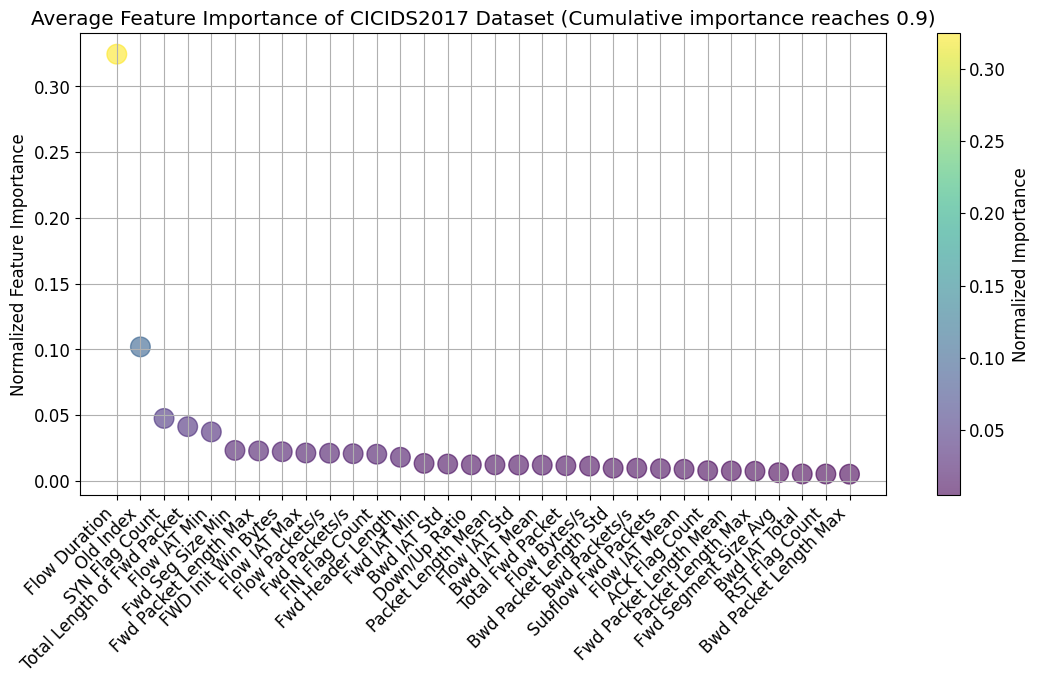

In [55]:
# Plot the feature importance of the top-3 models
plt.rcParams.update({'font.size': 12})

# Create a DataFrame for easier plotting
features = pd.DataFrame({
    'Feature': df.drop(['Label'],axis=1).columns,
    'Importance': avg_feature
})

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

# Calculate cumulative importance and filter features
features['Cumulative'] = features['Importance'].cumsum()
filtered_features = features[features['Cumulative'] <= 0.9]

# Plotting
plt.figure(figsize=(13, 6))
scatter = plt.scatter(x='Feature', y='Importance', s=200, c='Importance', cmap='viridis', alpha=0.6, data=filtered_features)
plt.colorbar(scatter, label='Normalized Importance')
plt.xticks(rotation=45, ha='right')
plt.title('Average Feature Importance of CICIDS2017 Dataset (Cumulative importance reaches 0.9)')
plt.ylabel('Normalized Feature Importance')
plt.grid(True)
plt.show()

In [56]:
print(fs)

['Flow Duration', 'Old Index', 'SYN Flag Count', 'Total Length of Fwd Packet', 'Flow IAT Min', 'Fwd Seg Size Min', 'Fwd Packet Length Max', 'FWD Init Win Bytes', 'Flow IAT Max', 'Flow Packets/s', 'Fwd Packets/s', 'FIN Flag Count', 'Fwd Header Length', 'Fwd IAT Min', 'Bwd IAT Std', 'Down/Up Ratio', 'Packet Length Mean', 'Flow IAT Std', 'Bwd IAT Mean', 'Total Fwd Packet', 'Flow Bytes/s', 'Bwd Packets/s', 'Bwd Packet Length Std', 'Subflow Fwd Packets', 'Flow IAT Mean', 'ACK Flag Count', 'Fwd Packet Length Mean', 'Packet Length Max', 'Fwd Segment Size Avg', 'RST Flag Count', 'Bwd IAT Total', 'Bwd Packet Length Max', 'Fwd IAT Mean']


### Data Balancing by Proposed TVAE-based Method

In [57]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_fs)

In [ ]:
# training_set, test_set = train_test_split(df, train_size=0.75, test_size=0.25, random_state=0, stratify=df['Label'])
# X_train = training_set[fs]
# y_train = training_set.iloc[:, -1]
# X_val = test_set[fs]
# y_val = test_set.iloc[:, -1]

In [ ]:
# training_set['Label'].value_counts()

Label
0    294673
1    120891
Name: count, dtype: int64

In [58]:
y_train = pd.Series(y_train)
y_val = pd.Series(y_val)

In [59]:
from sdv.single_table import TVAESynthesizer
# Identify the average number of samples per class
average_samples = y_train.value_counts().mean()

# Identify minority classes with less than half the average number of samples
minority_classes = y_train.value_counts()
minority_classes = minority_classes[minority_classes < average_samples / 2].index.tolist()

# Prepare an empty DataFrame to collect synthetic data
synthetic_data = pd.DataFrame()

In [61]:
y_train.index = X_train.index

In [62]:
# Generating synthetic samples for each minority class using TVAE
for cls in minority_classes:
    cls_samples = X_train[y_train == cls]
    num_samples_needed = int(average_samples - len(cls_samples))
    
    # Initialize the TVAE model with detected metadata
    tvaegan = TVAESynthesizer(metadata=metadata, cuda=True, verbose=True)
    
    # Fit the TVAE model on the minority class samples
    tvaegan.fit(cls_samples.assign(Label=y_train[y_train == cls]))  # add Label temporarily for TVAE training
    
    # Generate synthetic instances to match the average class sample size
    new_samples = tvaegan.sample(num_samples_needed)
    
    # Append the new synthetic instances to the synthetic data list
    synthetic_data = pd.concat([synthetic_data, new_samples], ignore_index=True)

Loss: -189.860: 100%|██████████| 300/300 [00:29<00:00, 10.20it/s]


In [63]:
# Concatenate the original and synthetic data to form a balanced dataset
balanced_data = pd.concat([X_train.assign(Label=y_train), synthetic_data], ignore_index=True)

# Display the new distribution of labels in the balanced dataset
print(balanced_data['Label'].value_counts())

# Prepare the balanced dataset for model training
X_train_balanced = balanced_data.drop(['Label'], axis=1)
y_train_balanced = balanced_data['Label']

Label
0    379348
2    159240
1     95424
Name: count, dtype: int64


In [64]:
X_val.reset_index(drop=True).to_csv(f"{CHECKPOINT_OUTPUT}/fs_X_val.csv", index=False)

In [65]:
X_train_balanced.to_csv(f"{CHECKPOINT_OUTPUT}/fs_X_train_balanced.csv", index=False)

In [66]:
y_val.reset_index(drop=True).to_csv(f"{CHECKPOINT_OUTPUT}/fs_y_val.csv", index=False)

In [67]:
y_train_balanced.to_csv(f"{CHECKPOINT_OUTPUT}/fs_y_val.csv", index=False)

# Testing

In [155]:
# X_train_balanced = df_fs.drop(['Label'], axis=1)
# y_train_balanced = df_fs['Label']

## Machine learning model training

### Training six base learners: 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

In [68]:
POST_FS_MODEL_OUTPUT = "./models/postfs"

### DT

Training time:  16.621636629104614
Prediction time per sample:  0.00015458482083808894
Cross-Validation scores:  [0.99147337 0.99993849 0.99984385]
Mean of Cross-Validation scores:  0.9970852375221023
Accuracy of DT: 0.9998806839946999
Precision of DT: 0.9998827157695889
Recall of DT: 0.9998806839946999
F1-score of DT: 0.9998811926999376
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       0.98      1.00      0.99       983

    accuracy                           1.00    159241
   macro avg       0.99      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



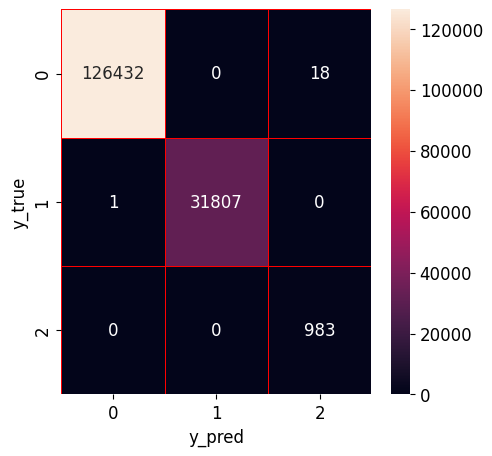

In [69]:
# %%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt


# Decision tree training and prediction with 3-fold cross-validation
dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_score(dt, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
dt.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val)*1000)

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [70]:
X_test_fs = X_test[fs]

In [ ]:
# X_test = df_test[fs]
# y_test = labelencoder.transform(df_test['Label'])

Prediction time per sample:  0.00015878472277688365
Accuracy of DT: 0.9992592200645537
Precision of DT: 0.9992594667991782
Recall of DT: 0.9992592200645537
F1-score of DT: 0.9992588981240075
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99591
           1       1.00      1.00      1.00     31808
           2       0.99      0.99      0.99       894

    accuracy                           1.00    132293
   macro avg       1.00      1.00      1.00    132293
weighted avg       1.00      1.00      1.00    132293



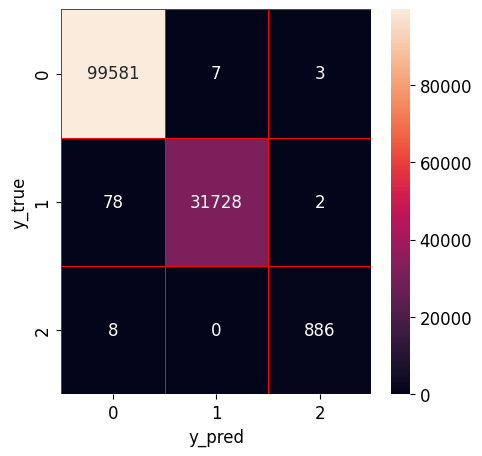

In [71]:
start = time.time()
y_predict = dt.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)

y_true = y_test

# Print out the cross-validation scores and mean of them
# print('Cross-Validation scores: ', dt_scores)
# print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [72]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt_untuned.pkl")

['./models/postfs/dt_untuned.pkl']

100%|██████████| 20/20 [02:47<00:00,  8.37s/trial, best loss: -0.9988580666337104]
Decision Tree: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 5}
Accuracy of DT: 0.9990266325883409
Precision of DT: 0.9991100331604272
Recall of DT: 0.9990266325883409
F1-score of DT: 0.9990508717716101
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       0.88      0.99      0.93       983

    accuracy                           1.00    159241
   macro avg       0.96      0.99      0.98    159241
weighted avg       1.00      1.00      1.00    159241



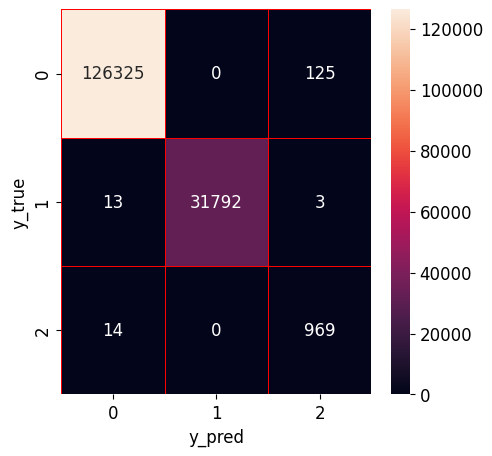

In [73]:
# Hyperparameter Optimization using BO-TPE

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = DecisionTreeClassifier(random_state=0, **params)
    score = cross_val_score(clf, X_train_balanced, y_train_balanced, n_jobs=8, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Decision Tree: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
dt = DecisionTreeClassifier(random_state=0, **best)
dt.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = dt.predict(X_val)
y_true = y_val

# Evaluation metrics
dt_score = dt.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [74]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt.pkl")

['./models/postfs/dt.pkl']

### RF

Training time:  27.866225242614746
Prediction time:  0.0008006705583568351 ms
Cross-Validation scores:  [0.99277934 0.99995741 0.99993376]
Mean of Cross-Validation scores:  0.9975568361127185
Accuracy of RF: 0.999930922312721
Precision of RF: 0.999931554271545
Recall of RF: 0.999930922312721
F1-score of RF: 0.9999310799357417
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       0.99      1.00      0.99       983

    accuracy                           1.00    159241
   macro avg       1.00      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



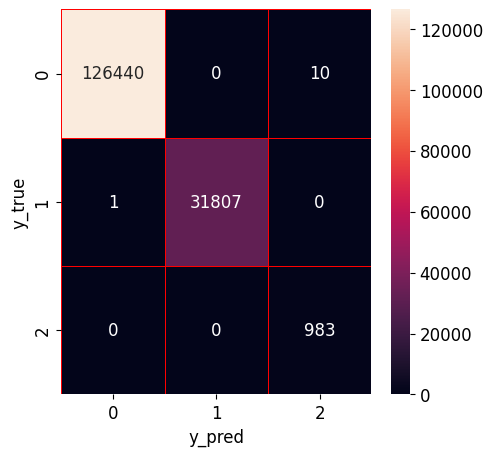

In [75]:
# %%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0, n_jobs=8)
rf_scores = cross_val_score(rf, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
rf.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# Evaluation metrics
rf_score = rf.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Prediction time:  0.0011483462680285709 ms
Accuracy of RF: 0.9993726047485506
Precision of RF: 0.9993726794216748
Recall of RF: 0.9993726047485506
F1-score of RF: 0.9993723116222005
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99591
           1       1.00      1.00      1.00     31808
           2       1.00      0.99      0.99       894

    accuracy                           1.00    132293
   macro avg       1.00      1.00      1.00    132293
weighted avg       1.00      1.00      1.00    132293



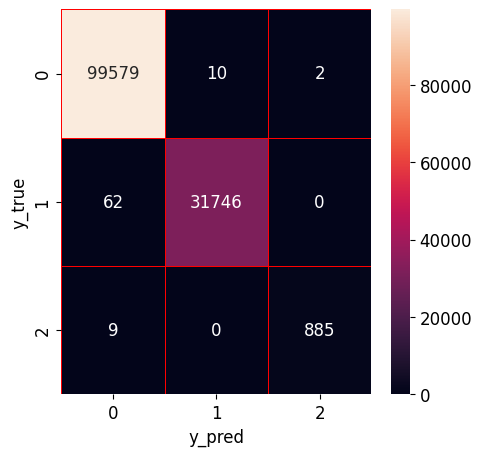

In [76]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test_fs)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
rf_score = rf.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [77]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_untuned.pkl")

['./models/postfs/rf_untuned.pkl']

100%|██████████| 20/20 [35:51<00:00, 107.58s/trial, best loss: -0.9994668878407333]
Random Forest: Hyperopt estimated optimum {'criterion': 'gini', 'max_depth': 11, 'max_features': 14, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 189}
Accuracy of RF: 0.9997174094611312
Precision of RF: 0.9997253864709652
Recall of RF: 0.9997174094611312
F1-score of RF: 0.9997195333872485
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       0.96      1.00      0.98       983

    accuracy                           1.00    159241
   macro avg       0.99      1.00      0.99    159241
weighted avg       1.00      1.00      1.00    159241



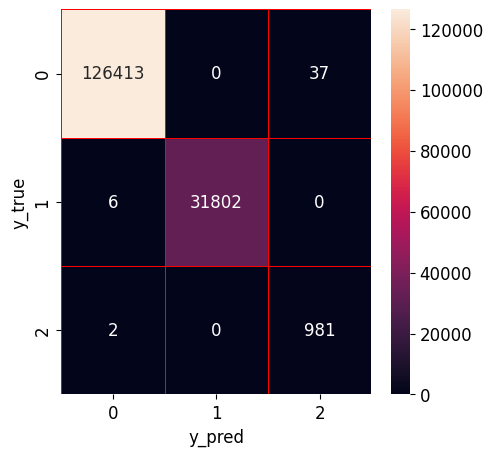

In [78]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = RandomForestClassifier(random_state=0, n_jobs=8, **params)
    score = cross_val_score(clf, X_train_balanced, y_train_balanced, scoring='accuracy', cv=StratifiedKFold(n_splits=3), n_jobs=8).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 40, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Random Forest: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
rf = RandomForestClassifier(random_state=0, **best)
rf.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = rf.predict(X_val)
y_true = y_val

# Evaluation metrics
rf_score = rf.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [79]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf.pkl")

['./models/postfs/rf.pkl']

In [80]:
import gc
gc.collect()

33418

### ET

Training time:  10.731411457061768
Prediction time:  0.0009391827380619541 ms
Cross-Validation scores:  [0.99765778 0.99998107 0.99995268]
Mean of Cross-Validation scores:  0.999197178506713
Accuracy of ET: 0.9999623212614842
Precision of ET: 0.9999624799643915
Recall of ET: 0.9999623212614842
F1-score of ET: 0.9999623607403136
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       0.99      1.00      1.00       983

    accuracy                           1.00    159241
   macro avg       1.00      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



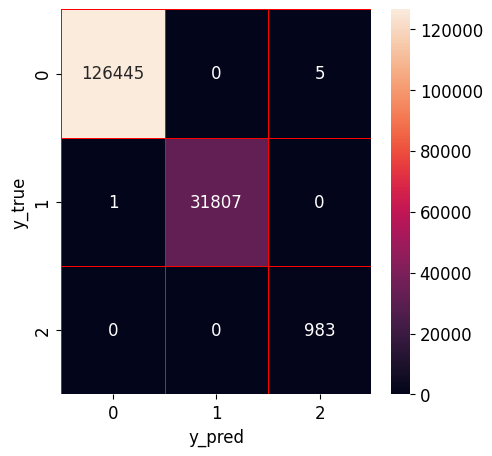

In [81]:
# %%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=8)
et_scores = cross_val_score(et, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
et.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(X_val) * 1000, 'ms')


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

# Evaluation metrics
et_score = et.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [82]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_untuned.pkl")

['./models/postfs/et_untuned.pkl']

100%|██████████| 20/20 [10:03<00:00, 30.17s/trial, best loss: -0.9999227144761802]
Extra Trees: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 39, 'max_features': 18, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 147}
Accuracy of ET: 0.9999748808409894
Precision of ET: 0.999974982641026
Recall of ET: 0.9999748808409894
F1-score of ET: 0.9999749061440217
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00       983

    accuracy                           1.00    159241
   macro avg       1.00      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



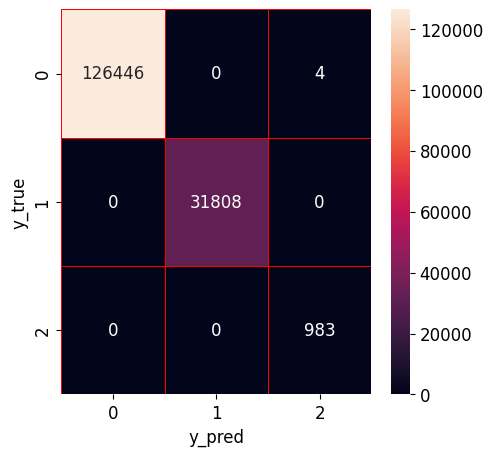

In [83]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = ExtraTreesClassifier(random_state=0, n_jobs=8, **params)
    score = cross_val_score(clf, X_train_balanced, y_train_balanced, scoring='accuracy', n_jobs=8, cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'max_features': hp.quniform('max_features', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Extra Trees: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
et = ExtraTreesClassifier(random_state=0, **best)
et.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = et.predict(X_val)
y_true = y_val

# Evaluation metrics
et_score = et.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [84]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et.pkl")

['./models/postfs/et.pkl']

In [85]:
import gc
gc.collect()

11315

### XGBoost

Training time:  3.307427167892456
Prediction time per sample:  0.00039486294537860336
Cross-Validation scores:  [0.99194655 0.99997634 0.99996215]
Mean of Cross-Validation scores:  0.9972950123159533
Accuracy of XGBoost: 0.9999748808409894
Precision of XGBoost: 0.9999749383590074
Recall of XGBoost: 0.9999748808409894
F1-score of XGBoost: 0.9999748950436762
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00       983

    accuracy                           1.00    159241
   macro avg       1.00      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



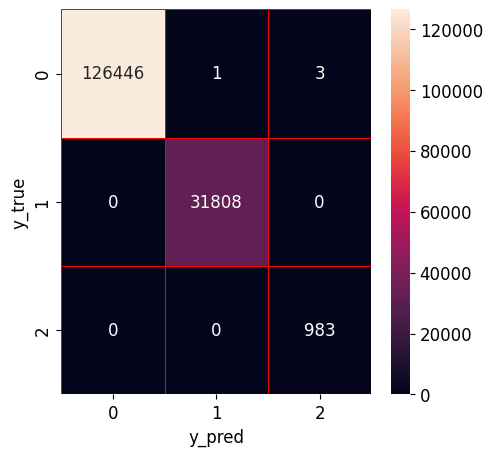

In [86]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=8)
xg_scores = cross_val_score(xg, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
xg.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

# Evaluation metrics
xg_score = xg.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Prediction time per sample:  0.0005770521501384548
Accuracy of XGBoost: 0.9948674533044076
Precision of XGBoost: 0.9949448089875041
Recall of XGBoost: 0.9948674533044076
F1-score of XGBoost: 0.9948824777686159
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     99591
           1       0.98      1.00      0.99     31808
           2       1.00      1.00      1.00       894

    accuracy                           0.99    132293
   macro avg       0.99      1.00      1.00    132293
weighted avg       0.99      0.99      0.99    132293



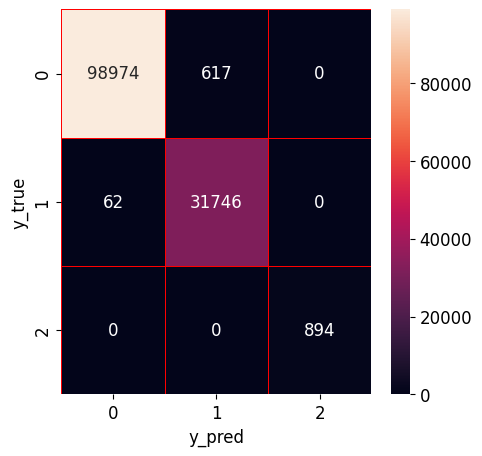

In [88]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs) * 1000)


y_true = y_test

# Evaluation metrics
xg_score = xg.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [89]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_untuned.pkl")

['./models/postfs/xg_untuned.pkl']

100%|██████████| 20/20 [00:48<00:00,  2.44s/trial, best loss: -0.9999874404204947]
XGBoost: Hyperopt estimated optimum {'learning_rate': 1.499207604095606, 'max_depth': 70, 'n_estimators': 10}
Accuracy of XGBoost: 0.9999874404204947
Precision of XGBoost: 0.9999874659221789
Recall of XGBoost: 0.9999874404204947
F1-score of XGBoost: 0.9999874467527322
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00       983

    accuracy                           1.00    159241
   macro avg       1.00      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



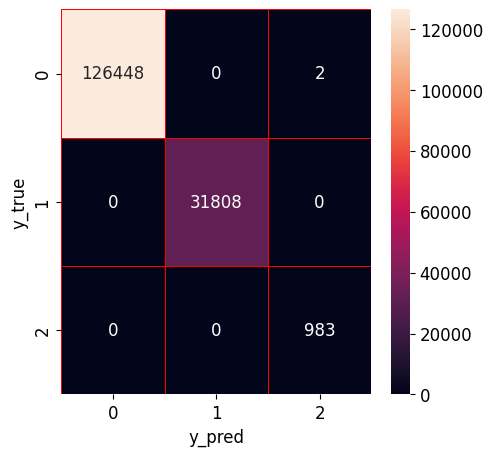

In [90]:
# Hyperparameter Optimization using BO-TPE

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate']))
    }
    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0, n_jobs=8, **params)
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_val)
    score = accuracy_score(y_val, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))

print("XGBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0, **best)
xg.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = xg.predict(X_val)
y_true = y_val

# Evaluation metrics
xg_score = xg.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [91]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg.pkl")

['./models/postfs/xg.pkl']

### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7402
[LightGBM] [Info] Number of data points in the train set: 422674, number of used features: 33
[LightGBM] [Info] Start training from score -0.513615
[LightGBM] [Info] Start training from score -1.893736
[LightGBM] [Info] Start training from score -1.381654
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

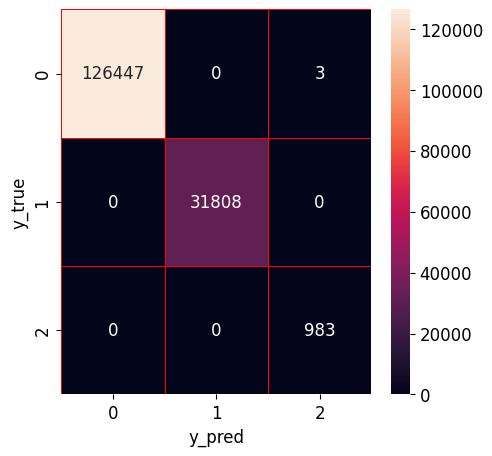

In [92]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)
lgbm_scores = cross_val_score(lgbm, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
lgbm.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)



y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [93]:
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_untuned.pkl")

['./models/postfs/lgbm_untuned.pkl']

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7405                     
[LightGBM] [Info] Number of data points in the train set: 634012, number of used features: 33
[LightGBM] [Info] Start training from score -0.513614 
[LightGBM] [Info] Start training from score -1.893738 
[LightGBM] [Info] Start training from score -1.381655 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

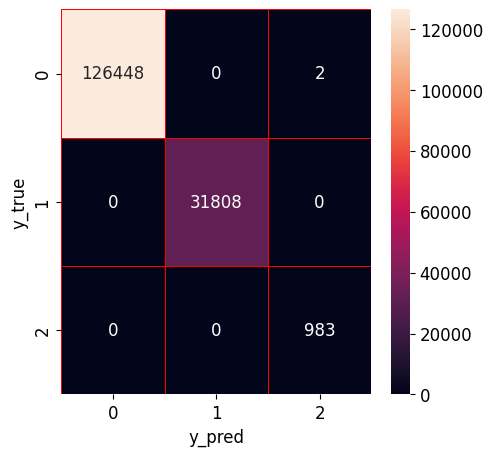

In [94]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_val)
    score = accuracy_score(y_val, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'num_leaves': hp.quniform('num_leaves', 10, 200, 5),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 5)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
lgbm = lgb.LGBMClassifier(random_state=0, **best)
lgbm.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = lgbm.predict(X_val)
y_true = y_val

# Evaluation metrics
lgbm_score = lgbm.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [95]:
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm.pkl")

['./models/postfs/lgbm.pkl']

### CatBoost

Training time:  55.476178884506226
Prediction time per sample:  0.0003570192493118172
Cross-Validation scores:  [0.99222572 0.99994795 0.99997161]
Mean of Cross-Validation scores:  0.9973817611591538
Accuracy of CatBoost: 0.9999686010512367
Precision of CatBoost: 0.9999686773297081
Recall of CatBoost: 0.9999686010512367
F1-score of CatBoost: 0.9999686247849724
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00       983

    accuracy                           1.00    159241
   macro avg       1.00      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



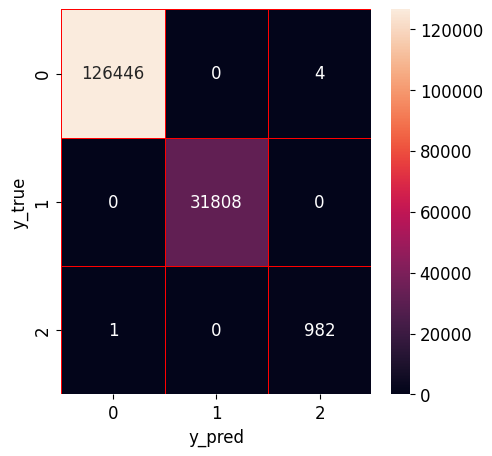

In [96]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, thread_count=8, verbose=False)
cat_scores = cross_val_score(cat, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)


# calculate the training time
start = time.time()
cat.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)


# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

# Evaluation metrics
cat_score = cat.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [97]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_untuned.pkl")

['./models/postfs/cat_untuned.pkl']

100%|██████████| 20/20 [31:57<00:00, 95.90s/trial, best loss: -0.9999874404204947]
CatBoost: Hyperopt estimated optimum {'depth': 4, 'iterations': 600, 'learning_rate': 0.2991018609903387}
Accuracy of CatBoost: 0.9999874404204947
Precision of CatBoost: 0.9999874659221789
Recall of CatBoost: 0.9999874404204947
F1-score of CatBoost: 0.9999874467527322
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126450
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00       983

    accuracy                           1.00    159241
   macro avg       1.00      1.00      1.00    159241
weighted avg       1.00      1.00      1.00    159241



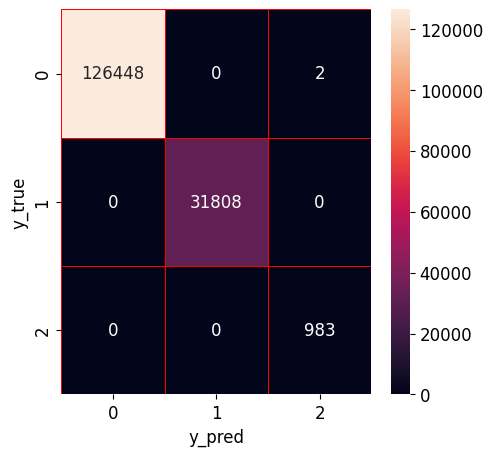

In [98]:
# Hyperparameter Optimization using BO-TPE

import catboost as cb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'iterations': int(params['iterations'])
    }
    clf = cb.CatBoostClassifier(random_state=0, verbose=False, thread_count=8, **params)
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_val)
    score = accuracy_score(y_val, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'depth': hp.quniform('depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'iterations': hp.quniform('iterations', 100, 1000, 100)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['depth'] = int(best['depth'])
best['learning_rate'] = best['learning_rate']
best['iterations'] = int(best['iterations'])

print("CatBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
cat = cb.CatBoostClassifier(random_state=0, verbose=False, **best)
cat.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = cat.predict(X_val)
y_true = y_val

# Evaluation metrics
cat_score = cat.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [99]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat.pkl")

['./models/postfs/cat.pkl']

In [100]:
# record the results
dt_train=dt.predict(X_train_balanced)
dt_test=dt.predict(X_val)
dt_prob_train=dt.predict_proba(X_train_balanced)
dt_prob_test=dt.predict_proba(X_val)

rf_train=rf.predict(X_train_balanced)
rf_test=rf.predict(X_val)
rf_prob_train=rf.predict_proba(X_train_balanced)
rf_prob_test=rf.predict_proba(X_val)

et_train=et.predict(X_train_balanced)
et_test=et.predict(X_val)
et_prob_train=et.predict_proba(X_train_balanced)
et_prob_test=et.predict_proba(X_val)

xg_train=xg.predict(X_train_balanced)
xg_test=xg.predict(X_val)
xg_prob_train=xg.predict_proba(X_train_balanced)
xg_prob_test=xg.predict_proba(X_val)

lgbm_train=lgbm.predict(X_train_balanced)
lgbm_test=lgbm.predict(X_val)
lgbm_prob_train=lgbm.predict_proba(X_train_balanced)
lgbm_prob_test=lgbm.predict_proba(X_val)

cat_train=cat.predict(X_train_balanced)
cat_test=cat.predict(X_val)
cat_prob_train=cat.predict_proba(X_train_balanced)
cat_prob_test=cat.predict_proba(X_val)


# Model Export

In [ ]:
# import joblib

# joblib.dump(dt, "Models/dt.pkl")
# joblib.dump(rf, "Models/rf.pkl")
# joblib.dump(et, "Models/et.pkl")
# joblib.dump(xg, "Models/xg.pkl")
# joblib.dump(lgbm, "Models/lgbm.pkl")
# joblib.dump(cat, "Models/cat.pkl")

['Models/cat.pkl']

In [ ]:
# lgbm_imported = joblib.load("Models/lgbm.pkl")

In [ ]:
# import_test = lgbm_imported.predict(X_val).reshape(-1,1)
# import_test

array([[0],
       [1],
       [3],
       ...,
       [0],
       [3],
       [3]])

In [ ]:
top_3_models

['rf', 'et', 'lgbm']

In [ ]:
fs

['Bwd Packet Length Min',
 'Bwd Packet Length Std',
 'Init_Win_bytes_forward',
 'Average Packet Size',
 'Init_Win_bytes_backward',
 'PSH Flag Count',
 'Bwd Packets/s',
 'Fwd PSH Flags',
 'Avg Bwd Segment Size',
 'Bwd Header Length',
 'Fwd Header Length',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'min_seg_size_forward',
 'Bwd Packet Length Mean',
 'Fwd Header Length.1',
 'Flow Bytes/s',
 'Bwd Packet Length Max',
 'Max Packet Length',
 'Flow IAT Min',
 'Total Length of Fwd Packets',
 'Fwd Packet Length Mean',
 'Total Length of Bwd Packets',
 'Fwd Packet Length Max',
 'Fwd IAT Min',
 'Avg Fwd Segment Size',
 'Total Fwd Packets',
 'Subflow Bwd Bytes',
 'Subflow Fwd Bytes',
 'Flow IAT Max',
 'Total Backward Packets',
 'Fwd IAT Mean',
 'Bwd IAT Min',
 'act_data_pkt_fwd',
 'Fwd Packets/s',
 'URG Flag Count',
 'Flow IAT Std',
 'Min Packet Length']

## Model selection

In [101]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]



In [102]:
top_3_models

['et', 'rf', 'cat']

In [103]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)


dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)
lgbm_test=lgbm_test.reshape(-1, 1)
cat_test=cat_test.reshape(-1, 1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9
[LightGBM] [Info] Number of data points in the train set: 634012, number of used features: 3
[LightGBM] [Info] Start training from score -0.513614
[LightGBM] [Info] Start training from score -1.893738
[LightGBM] [Info] Start training from score -1.381655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

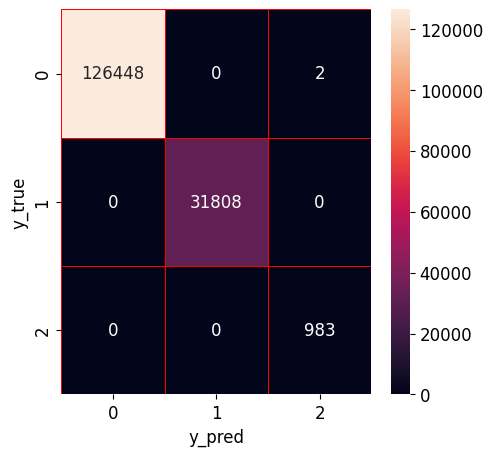

In [104]:
# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

# Stack the predictions of the top-3 models
x_train_balanced = np.concatenate(top_3_train_predictions, axis=1)
x_val = np.concatenate(top_3_test_predictions, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)
y_predict=stk.predict(x_val)
y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [105]:
joblib.dump(stk, f"{POST_FS_MODEL_OUTPUT}/stk1.pkl")

['./models/postfs/stk1.pkl']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 634012, number of used features: 9
[LightGBM] [Info] Start training from score -0.513614
[LightGBM] [Info] Start training from score -1.893738
[LightGBM] [Info] Start training from score -1.381655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

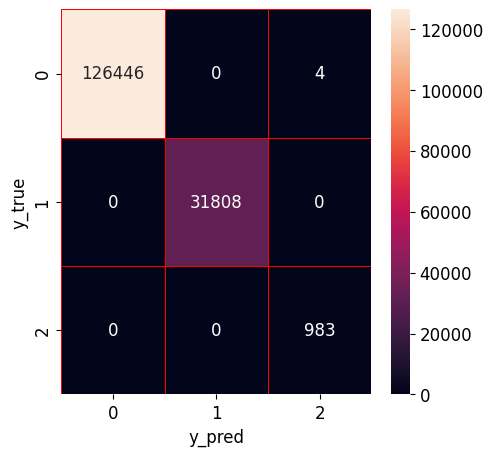

In [106]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
x_train_balanced = np.concatenate(top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_test_proba, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)
y_predict=stk.predict(x_val)
y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [107]:
joblib.dump(stk, f"{POST_FS_MODEL_OUTPUT}/stk2.pkl")

['./models/postfs/stk2.pkl']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1966
[LightGBM] [Info] Number of data points in the train set: 634012, number of used features: 12
[LightGBM] [Info] Start training from score -0.513614
[LightGBM] [Info] Start training from score -1.893738
[LightGBM] [Info] Start training from score -1.381655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

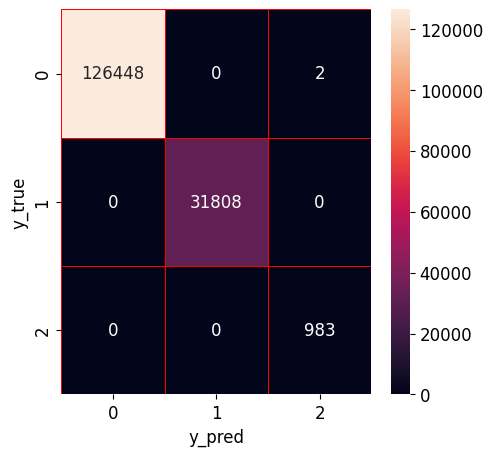

In [108]:
# Ensemble method 3: hybrid stacking
# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_train_balanced = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_test_predictions + top_3_test_proba, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)
y_predict=stk.predict(x_val)
y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

# PS: the hyperparameter optimization process is the same as the previous steps

In [109]:
joblib.dump(stk, f"{POST_FS_MODEL_OUTPUT}/stk3.pkl")

['./models/postfs/stk3.pkl']

# Final Test

In [210]:
# df_test = pd.read_csv('/mnt/extra/datasets/processed/friday_annotated_test_rerun.csv')
# df_test

In [211]:
# X_test = df_test[fs]
# X_test

In [212]:
# y_test = df_test['Label']
# y_test

In [213]:
# y_test = labelencoder.transform(y_test)

In [110]:
# record the results
dt_test_real=dt.predict(X_test_fs)
dt_prob_test_real=dt.predict_proba(X_test_fs)

rf_test_real=rf.predict(X_test_fs)
rf_prob_test_real=rf.predict_proba(X_test_fs)

et_test_real=et.predict(X_test_fs)
et_prob_test_real=et.predict_proba(X_test_fs)

xg_test_real=xg.predict(X_test_fs)
xg_prob_test_real=xg.predict_proba(X_test_fs)

lgbm_test_real=lgbm.predict(X_test_fs)
lgbm_prob_test_real=lgbm.predict_proba(X_test_fs)

cat_test_real=cat.predict(X_test_fs)
cat_prob_test_real=cat.predict_proba(X_test_fs)

In [111]:
dt_test_real=dt_test_real.reshape(-1, 1)
rf_test_real=rf_test_real.reshape(-1, 1)
et_test_real=et_test_real.reshape(-1, 1)
xg_test_real=xg_test_real.reshape(-1, 1)
lgbm_test_real=lgbm_test_real.reshape(-1, 1)
cat_test_real=cat_test_real.reshape(-1, 1)

Accuracy of Stacking: 0.9947313916836114
Precision of Stacking: 0.9948111329565422
Recall of Stacking: 0.9947313916836114
F1-score of Stacking: 0.9947467926743445
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     99591
           1       0.98      1.00      0.99     31808
           2       1.00      0.99      1.00       894

    accuracy                           0.99    132293
   macro avg       0.99      0.99      0.99    132293
weighted avg       0.99      0.99      0.99    132293



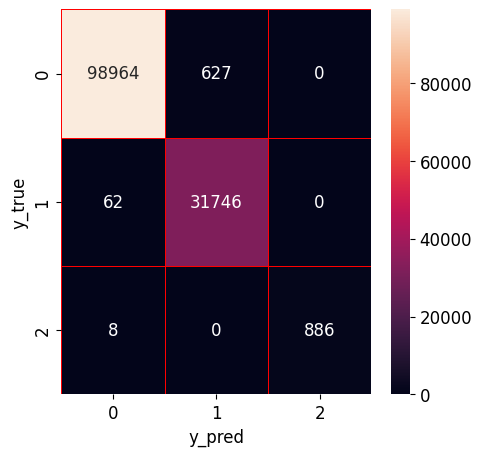

In [112]:
y_predict=lgbm.predict(X_test_fs)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [113]:
# Ensemble method 3: hybrid stacking
# Get the predictions and prediction probabilities of the top-3 models
top_3_test_real_predictions = [globals()[model.lower() + '_test_real'] for model in top_3_models]

top_3_test_real_proba = [globals()[model.lower() + '_prob_test_real'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_test_real = np.concatenate(top_3_test_real_predictions + top_3_test_real_proba, axis=1)

Accuracy of Stacking: 0.9947843045361433
Precision of Stacking: 0.994864619086257
Recall of Stacking: 0.9947843045361433
F1-score of Stacking: 0.9947998706536586
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     99591
           1       0.98      1.00      0.99     31808
           2       1.00      1.00      1.00       894

    accuracy                           0.99    132293
   macro avg       0.99      1.00      1.00    132293
weighted avg       0.99      0.99      0.99    132293



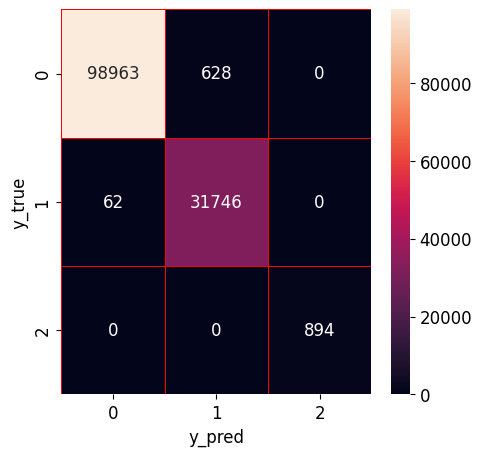

In [114]:
y_predict=stk.predict(x_test_real)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()